# Hourly Imbalance

This section analyzes the hourly system imbalance in the Italian electricity market (*TERNA_SUNSET_SEGNO_QH*), focusing on the characteristics of imbalances in the northern and southern macrozones.

In [86]:
import sys
import os
import pandas as pd
import numpy as np

# Add the source directory to the system path
sys.path.append(os.path.abspath('../../src'))
from open_data import fetch_db_table_sqlserver16
import matplotlib.pyplot as plt

# SQL query to fetch data
sql_query = "SELECT * FROM TERNA_SUNSET_SEGNO_QH" 
qh = fetch_db_table_sqlserver16(sql=sql_query, verbose=False)
qh = qh.sort_values(by='ORAINI')


c:\imbalance_forecast\src\open_data.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, con, params=parameters)


In [87]:
# Filter the DataFrame for the relevant columns and rows
qh = qh[['MACROZONA', 'ORAINI', 'SBIL_MWH']]
# Convert ORAINI to datetime using the correct method
qh['ORAINI'] = pd.to_datetime(qh['ORAINI'], format='%Y%m%d%H%M')
qh.set_index('ORAINI', inplace=True)
# Nord
qh_nord = qh[qh['MACROZONA'] == 'NORD']
# Sud
qh_sud = qh[qh['MACROZONA'] == 'SUD']
# Print the first few rows of the DataFrame
qh_nord

,MACROZONA,SBIL_MWH
ORAINI,,
2019-01-01 00:00:00,NORD,-47.312
2019-01-01 00:15:00,NORD,-30.343
2019-01-01 00:30:00,NORD,-20.311
2019-01-01 00:45:00,NORD,-13.934
2019-01-01 01:00:00,NORD,-65.080
...,...,...
2024-11-13 14:30:00,NORD,-70.166
2024-11-13 14:45:00,NORD,-188.001
2024-11-13 15:00:00,NORD,191.529


In [88]:
# Resample to hourly data and take the sum of 'SBIL_MWH' for each hour
h_nord = qh_nord.resample('H').sum()

# Clean the 'MACROZONA' column to retain only 'NORD'
h_nord['MACROZONA'] = h_nord['MACROZONA'].str[:4]

# Display the first few rows of the resampled data
print(h_nord.head())

                    MACROZONA  SBIL_MWH
ORAINI                                 
2019-01-01 00:00:00      NORD  -111.900
2019-01-01 01:00:00      NORD  -112.451
2019-01-01 02:00:00      NORD   -88.849
2019-01-01 03:00:00      NORD   127.792
2019-01-01 04:00:00      NORD   162.699


C:\Users\samueledelia\AppData\Local\Temp\3\ipykernel_12396\3058485339.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h_nord = qh_nord.resample('H').sum()


In [89]:
# Resample to hourly data and take the sum of 'SBIL_MWH' for each hour
h_sud = qh_sud.resample('H').sum()

# Clean the 'MACROZONA' column to retain only 'SUD'
h_sud['MACROZONA'] = h_sud['MACROZONA'].str[:3]

# Display the first few rows of the resampled data
print(h_sud.head())

C:\Users\samueledelia\AppData\Local\Temp\3\ipykernel_12396\160998093.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  h_sud = qh_sud.resample('H').sum()


                    MACROZONA  SBIL_MWH
ORAINI                                 
2019-01-01 00:00:00       SUD  -350.631
2019-01-01 01:00:00       SUD  -980.001
2019-01-01 02:00:00       SUD -1024.145
2019-01-01 03:00:00       SUD  -636.110
2019-01-01 04:00:00       SUD  -356.706


### Nord

In [90]:
print("Macro-scale descriptive stats (Nord macrozone):")
print(h_nord["SBIL_MWH"].describe(),"\n")

Macro-scale descriptive stats (Nord macrozone):
count    51448.000000
mean        76.514819
std        519.650158
min      -3943.523000
25%       -195.972250
50%         60.330000
75%        330.828250
max       8058.446000
Name: SBIL_MWH, dtype: float64 



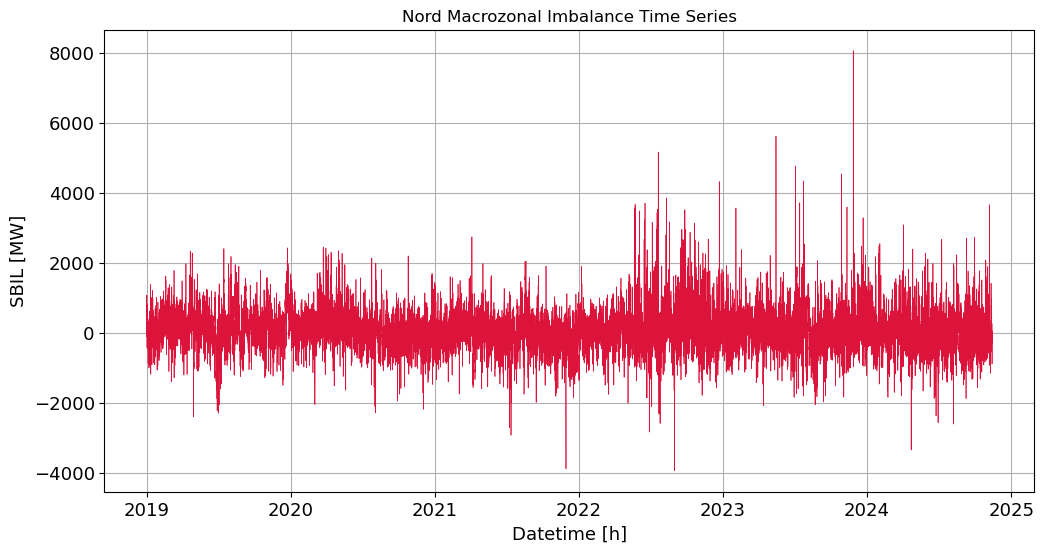

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(h_nord["SBIL_MWH"], linewidth=0.5, c='crimson', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

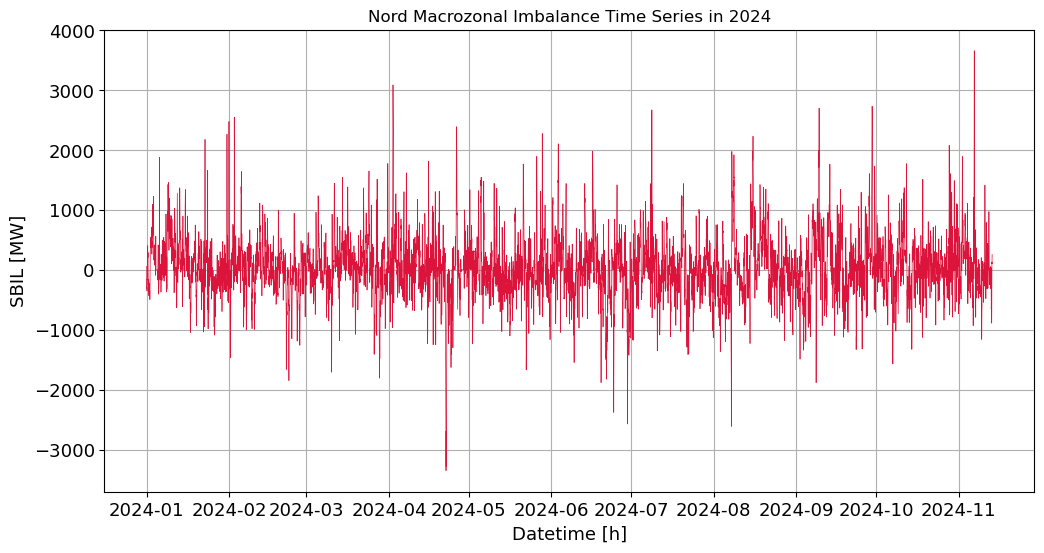

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(h_nord["SBIL_MWH"].loc['2024'], linewidth=0.5, c='crimson', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series in 2024")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

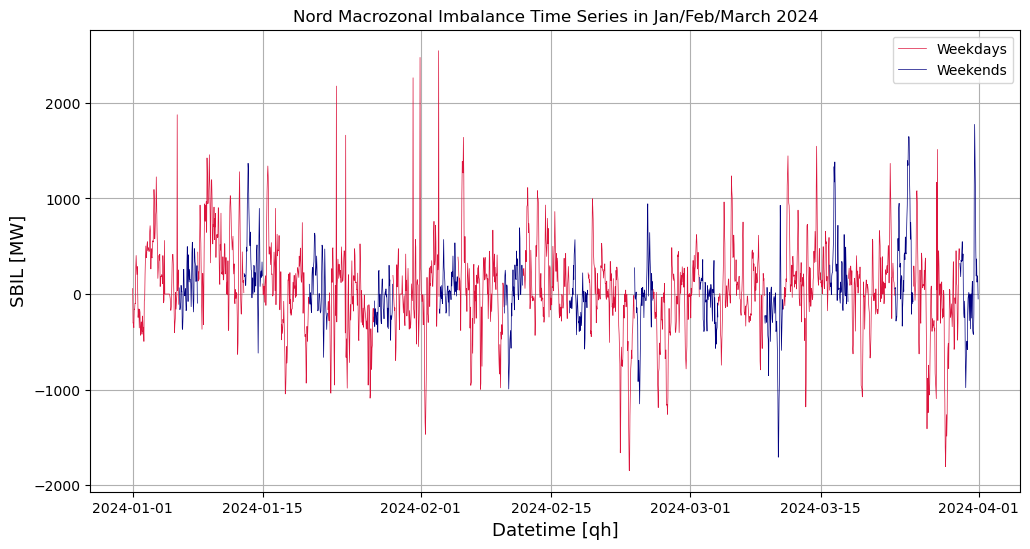

In [93]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Filter data for the specific month
data = h_nord["SBIL_MWH"].loc['2024-01':'2024-03'] 

# Create two versions of the data for plotting with NaNs to break the lines for weekdays/weekends
weekends = np.where(data.index.weekday.isin([5, 6]), data, np.nan)  # Set weekdays to NaN
weekdays = np.where(~data.index.weekday.isin([5, 6]), data, np.nan)  # Set weekends to NaN

# Plot weekdays (continuous line, but only valid data points)
ax.plot(data.index, weekdays, linewidth=0.5, color='crimson', label='Weekdays')

# Plot weekends (continuous line, but only valid data points)
ax.plot(data.index, weekends, linewidth=0.5, color='navy', label='Weekends')

# Set labels and title
ax.set_xlabel("Datetime [qh]", fontsize=13)
ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Nord Macrozonal Imbalance Time Series in Jan/Feb/March 2024")
plt.grid()
ax.legend()  # Add a legend to differentiate the lines

plt.show()

<h3>KDE</h3>

The Kernel Density Estimator (KDE) provides a rational and visually pleasant representation of the data distribution, even if the data distribution is too irregular and does not resemble any of the usual PDFs

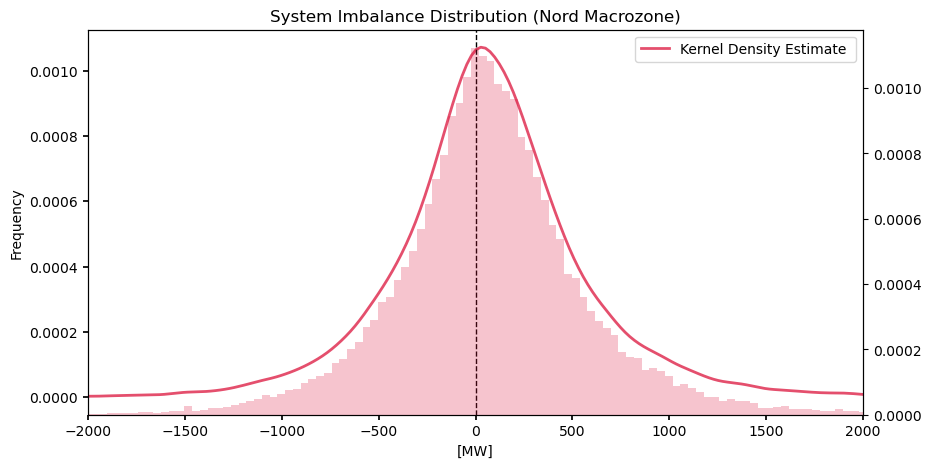

In [94]:
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
h_nord.plot(y="SBIL_MWH", ax=ax, kind="kde", color='crimson', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate ")

# Plot Histogram
h_nord.plot(y="SBIL_MWH", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='crimson', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("System Imbalance Distribution (Nord Macrozone)")
ax.set_xlabel("[MW]")

# Set x-limits for better visibility
ax.set_xlim(-2000, 2000)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

<h3> QQ-plot </h3>

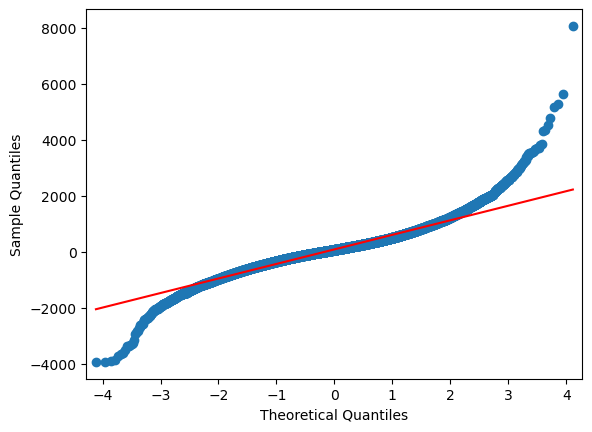

In [95]:
import numpy as np 
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(h_nord["SBIL_MWH"], line='s')

py.show()

In [96]:
from scipy.stats import kstest, norm
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(qh_nord["SBIL_MWH"], cdf="norm")
print(ks_statistic, p_value)

# Hypothesis test result:
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject H0: The data does not follow a normal distribution (H1).")
else:
    print("Fail to reject H0: The data follows a normal distribution (H0).")

0.5399597615639202 0.0
Reject H0: The data does not follow a normal distribution (H1).


In [97]:
from statsmodels.tsa.stattools import adfuller

# Assuming h_nord["SBIL_MWH"] is your time series data
adf_result = adfuller(h_nord["SBIL_MWH"])

# Print the result of the test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("  ")
# Hypothesis test result:
alpha = 0.05  # significance level

# Interpret the result based on p-value
if adf_result[1] < alpha:
    print("Reject H0: The time series is stationary (H1).")
else:
    print("Fail to reject H0: The time series is non-stationary (H0).")

ADF Statistic: -22.08277634007622
p-value: 0.0
Used Lag: 48
Number of Observations Used: 51399
Critical Values: {'1%': -3.430477232565075, '5%': -2.8615962342144847, '10%': -2.566799931606663}
  
Reject H0: The time series is stationary (H1).


<h3>Hourly Distribution </h3>

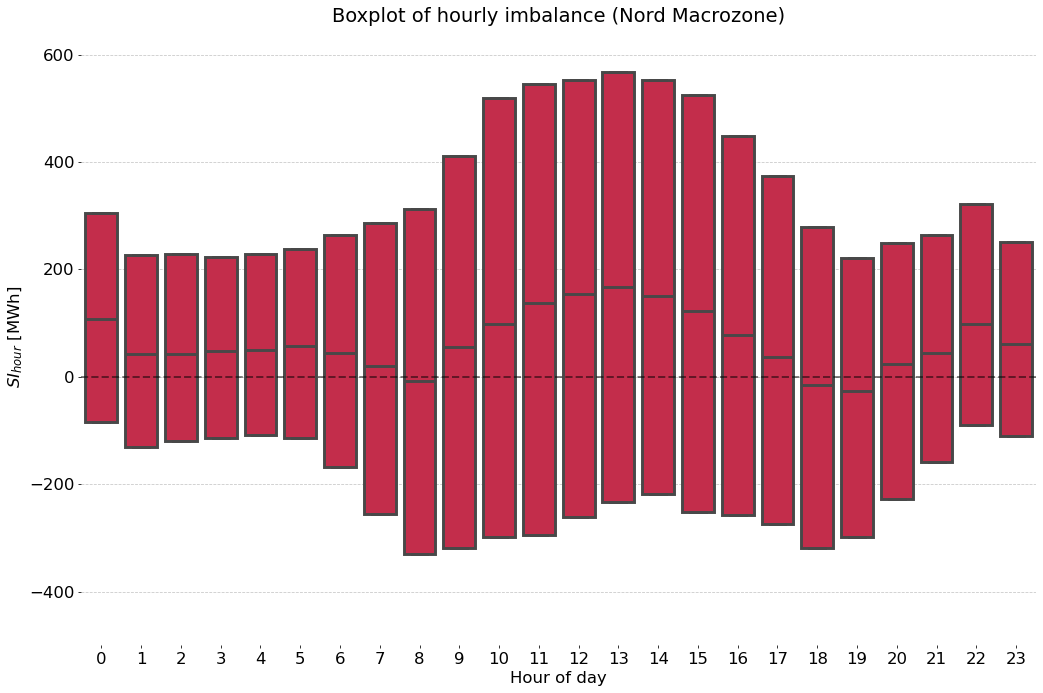

In [98]:
import seaborn as sns

DPI = 70

# Ensure you are working on a copy of the DataFrame
h_nord_copy = h_nord.copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
h_nord_copy.loc[:, 'hour'] = h_nord_copy.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=h_nord_copy, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='crimson', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)
ax.set_title("Boxplot of hourly imbalance (Nord Macrozone)", fontsize=20)
# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-500, 650])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()

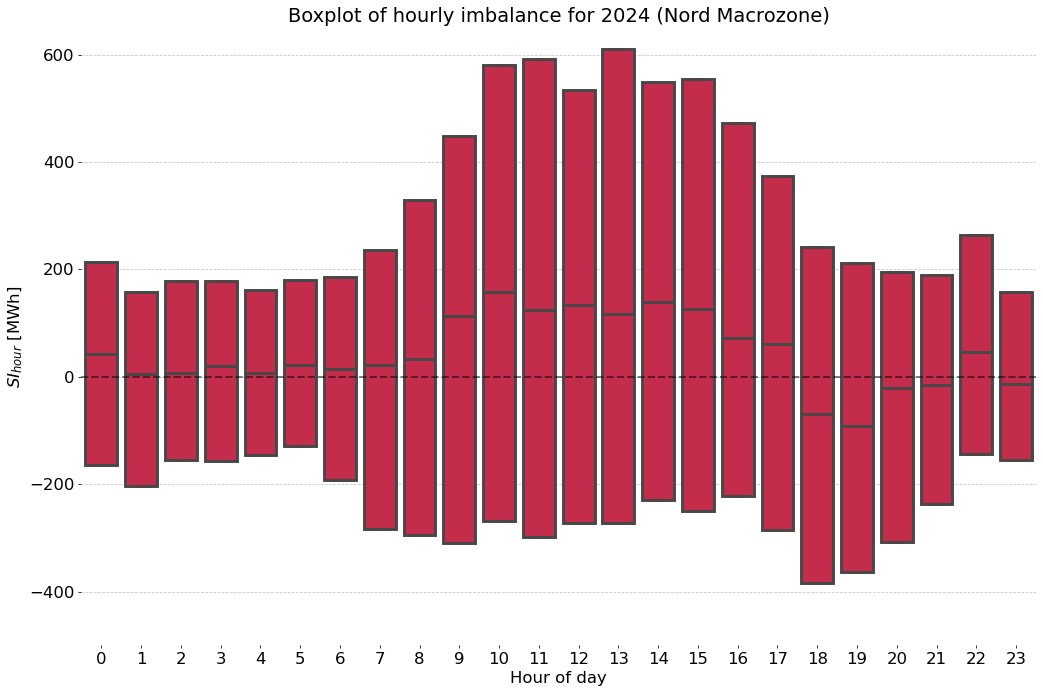

In [99]:
import seaborn as sns

DPI = 70

# Ensure you are working on a copy of the DataFrame
h_nord_2024 = h_nord.loc["2024"].copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
h_nord_2024.loc[:, 'hour'] = h_nord_2024.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=h_nord_2024, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='crimson', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)
ax.set_title("Boxplot of hourly imbalance for 2024 (Nord Macrozone)", fontsize=20)
# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-500, 650])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


<h3>Volume over time</h3>

In [100]:
def calculate_imbalance_volume(group, how="sum"):
    if how == "sum":
        return group.abs().sum()*1e-3  # To obtain GWh 
    elif how=="mean":
        return group.abs().mean() # To obtain average MW

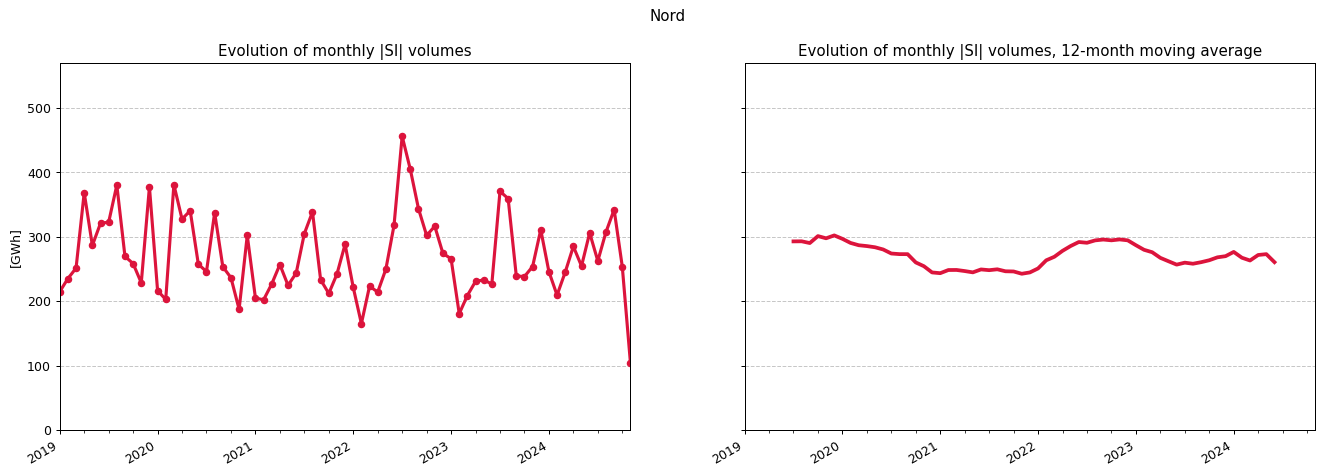

In [101]:
h_nord_copy['year'] = h_nord.index.year
h_nord_copy['month'] = h_nord.index.month

# Group by year and month, then apply the custom imbalance volume calculation
agg_month = (
    h_nord_copy
    .groupby(by=["year", "month"])["SBIL_MWH"]
    .apply(calculate_imbalance_volume, how="sum")
)

# Adjust the date index range for the aggregated data
agg_month.index = pd.date_range(
    start=pd.Timestamp(f"{agg_month.index[0][0]}-{agg_month.index[0][1]}") - pd.DateOffset(months=0),
    end=pd.Timestamp(f"{agg_month.index[-1][0]}-{agg_month.index[-1][1]}") + pd.DateOffset(months=0),
    freq="1MS"
)

rolling_window = 12

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=[18, 6], dpi=90, sharex=True, sharey=True)

# Plot original monthly imbalance volume on the first subplot
agg_month.plot(ax=ax[0],
               ylabel="[GWh]",
               c="crimson",
               linewidth=2.5,  # Increased linewidth for better visibility
               title=f"Evolution of monthly |SI| volumes")
agg_month.plot(ax=ax[0],
               style=".",
               color="crimson",
               markersize=10)

# Plot rolling mean with the specified rolling window on the second subplot
agg_month.rolling(rolling_window, center=True).mean().plot(ax=ax[1],
                                                           ylabel="[GWh]",
                                                           c="crimson",
                                                           linewidth=3,  # Increased line thickness for rolling average
                                                           title=f"Evolution of monthly |SI| volumes, {rolling_window}-month moving average")

# Set the y-axis limits dynamically based on the maximum value
plt.ylim(0, 1.25 * agg_month.max())


# Enable horizontal grid lines
ax[0].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to first plot
ax[1].grid(True, axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid to second plot

# Automatically adjust x-axis label formatting
fig.autofmt_xdate()
fig.suptitle('Nord')
# Display the plot
plt.show()


<h3> ACF </h3>

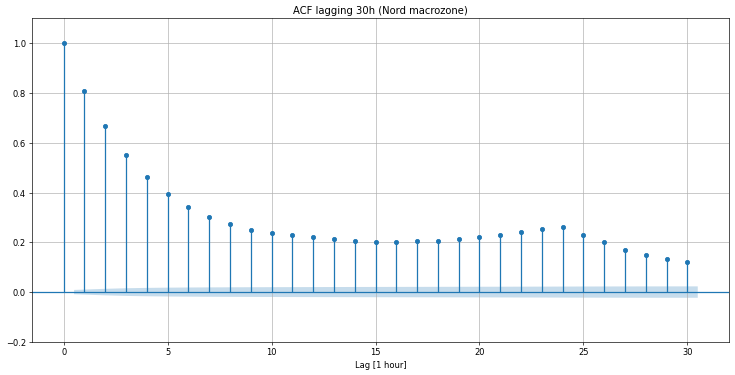

In [102]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_nord["SBIL_MWH"], alpha=.05, lags=30,
                         ax=ax, title="ACF lagging 30h (Nord macrozone)")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()

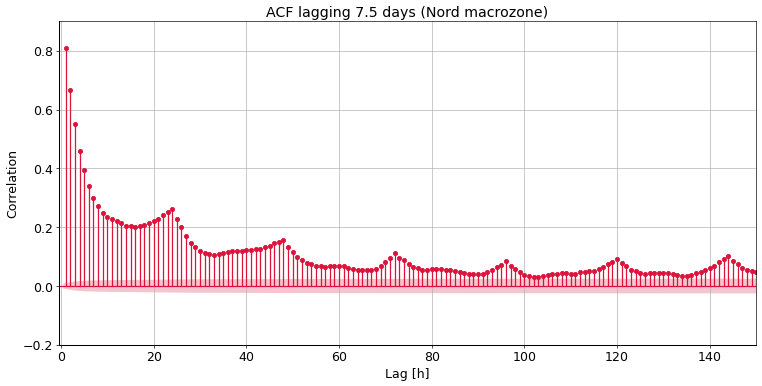

In [103]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_nord["SBIL_MWH"], alpha=.05, lags=24*7.5,
                         zero=False,
                         ax=ax,
                         color="crimson", vlines_kwargs={"colors": "crimson"})

ax.set_title("ACF lagging 7.5 days (Nord macrozone)", fontsize=17)
plt.ylim(-0.2, 0.9)
plt.xlim(-0.5, 24*7.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [h]", fontsize=15)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("crimson")
plt.grid()
plt.show()

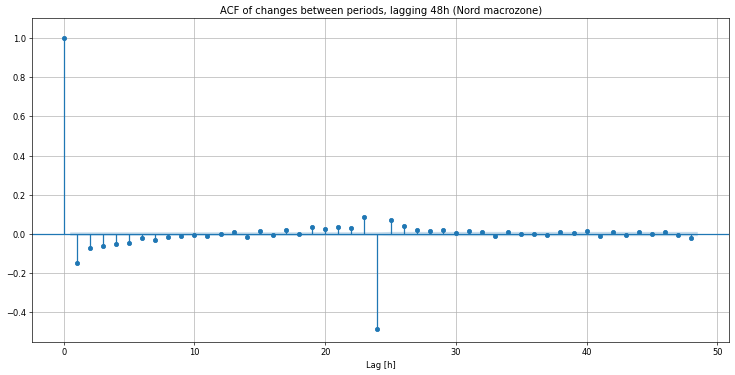

In [104]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_nord["SBIL_MWH"].diff().diff(24).dropna(), alpha=.05, lags=48,
                         ax=ax, title="ACF of changes between periods, lagging 48h (Nord macrozone)")
plt.ylim(-0.55, 1.1)
plt.xlabel('Lag [h]')
plt.grid()
plt.show()

<h3> PACF </h3>

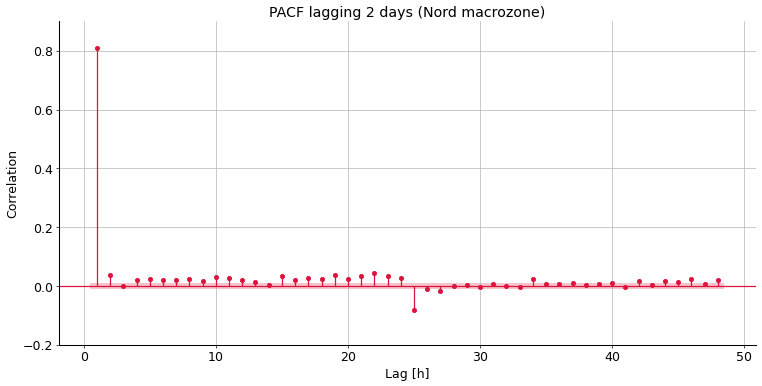

In [105]:
from matplotlib.collections import PolyCollection

fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(h_nord["SBIL_MWH"], alpha=.05, lags=24*2, 
                         zero=False,
                         ax=ax,
                         color="crimson", vlines_kwargs={"colors": "crimson"})
plt.ylim(-0.2, 0.9)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [h]", fontsize=15)
ax.set_title("PACF lagging 2 days (Nord macrozone)", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("crimson")
plt.grid()
plt.show()

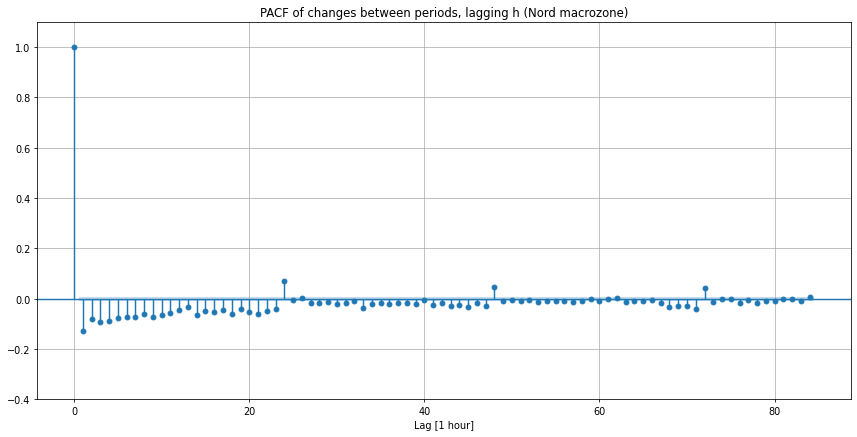

In [106]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(h_nord["SBIL_MWH"].diff().dropna(), alpha=.05, lags=24*3.5, method="ywm", 
                          ax=ax, title="PACF of changes between periods, lagging h (Nord macrozone)")
plt.ylim([-0.4,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()

<h3>STL decomposition </h3>

STL is a versatile and robust method for decomposing time series. STL is an acronym for “Seasonal and Trend decomposition using Loess”, while Loess is a method for estimating nonlinear relationships. 

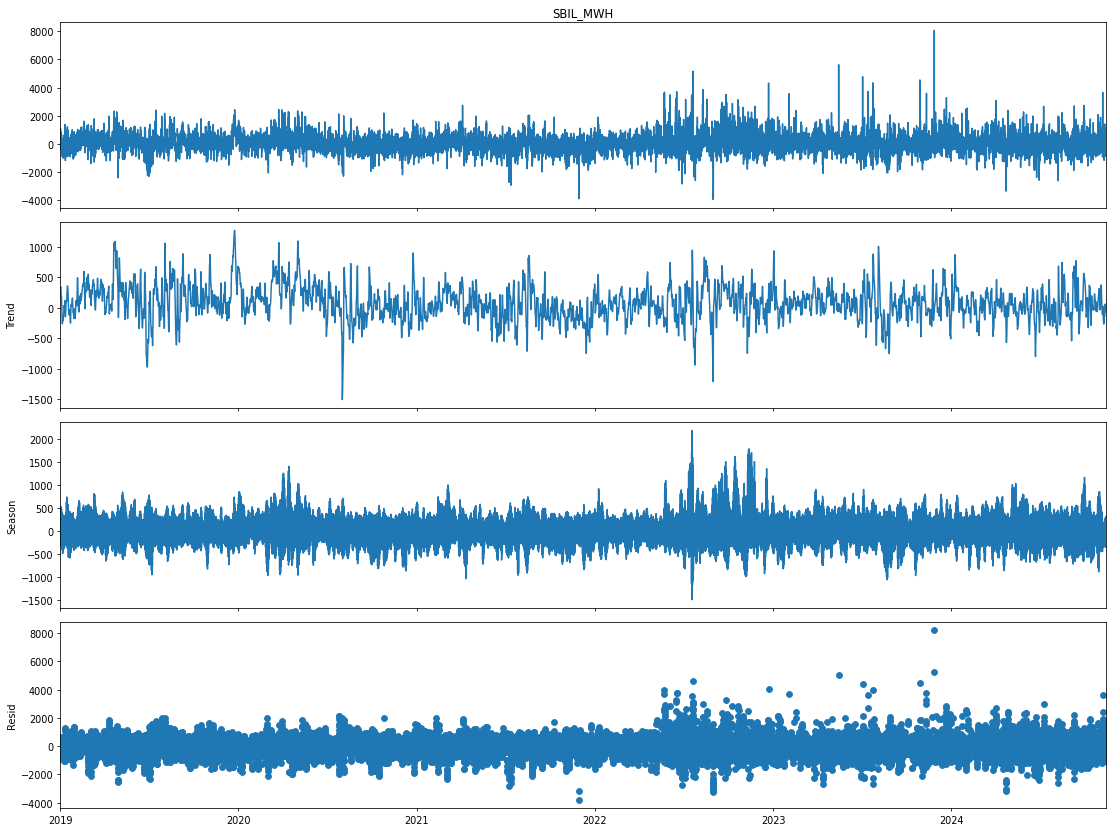

In [107]:
from statsmodels.tsa.seasonal import STL

# Attempt STL decomposition:
try_STL = True

if try_STL:
    decomp = STL(endog=h_nord["SBIL_MWH"], robust = True).fit() 
    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()

### Sud

In [108]:
print("Macro-scale descriptive stats (Sud Macrozone):")
print(h_sud["SBIL_MWH"].describe(),"\n")

Macro-scale descriptive stats (Sud Macrozone):
count    51448.000000
mean        94.580660
std        544.093678
min      -4264.372000
25%       -219.898500
50%         90.206500
75%        409.498250
max       6190.326000
Name: SBIL_MWH, dtype: float64 



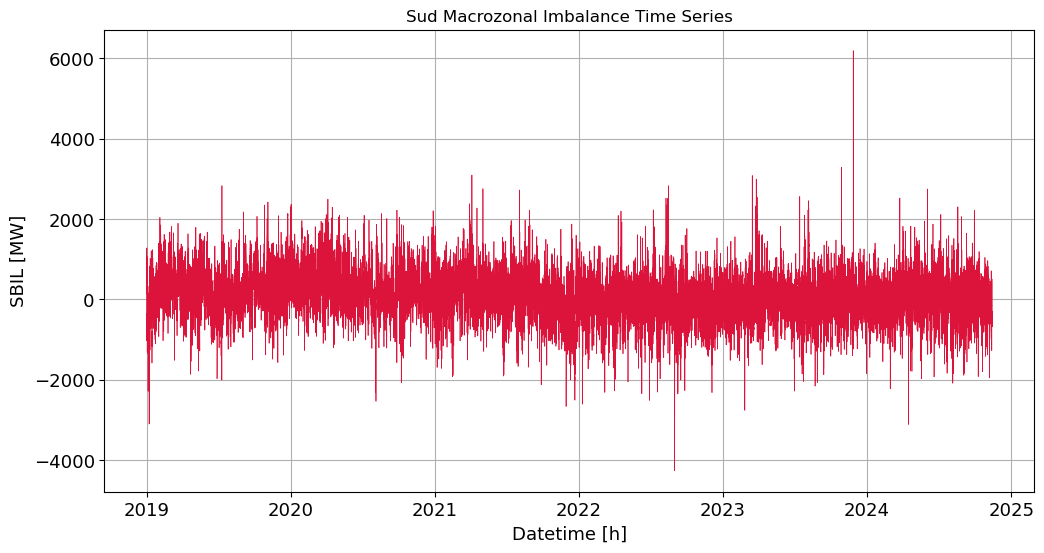

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(h_sud["SBIL_MWH"], linewidth=0.5, c='crimson', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Sud Macrozonal Imbalance Time Series")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

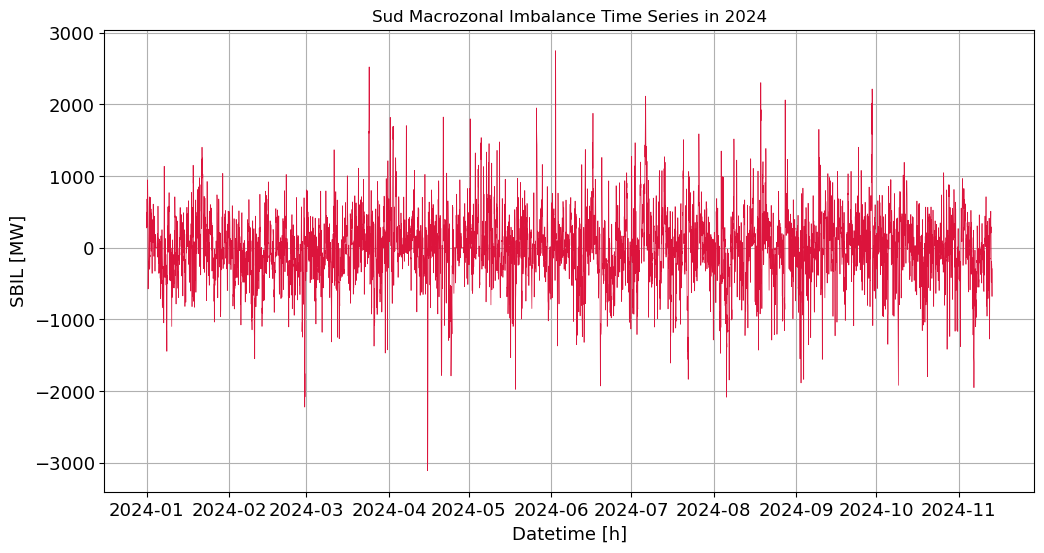

In [110]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(h_sud["SBIL_MWH"].loc['2024'], linewidth=0.5, c='crimson', alpha=1)
ax.set_xlabel("Datetime [h]", fontsize=13); ax.set_ylabel("SBIL [MW]", fontsize=13)
plt.title("Sud Macrozonal Imbalance Time Series in 2024")
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.grid()

plt.show()

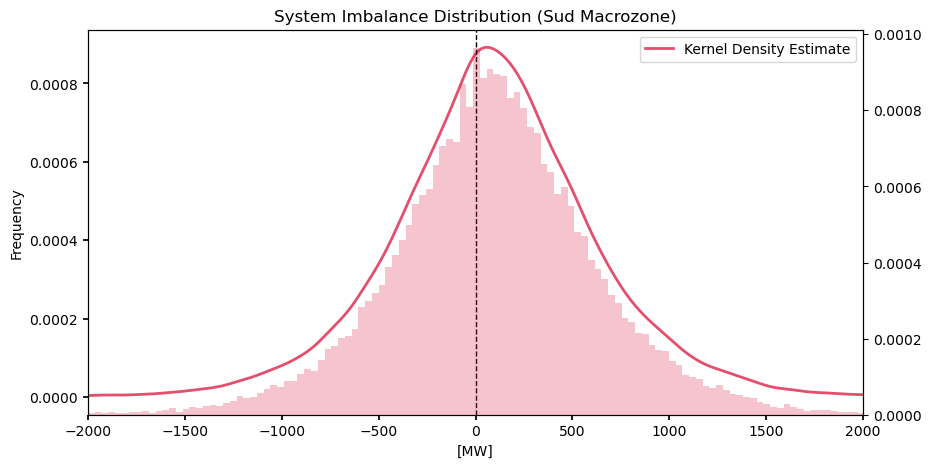

In [111]:
# Parameters
n_bins = 300  
DPI = 100  

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), dpi=DPI)

# Plot Kernel Density Estimate (KDE)
h_sud.plot(y="SBIL_MWH", ax=ax, kind="kde", color='crimson', alpha=0.75,
        linewidth=2, label="Kernel Density Estimate")

# Plot Histogram
h_sud.plot(y="SBIL_MWH", ax=ax, kind="hist", bins=n_bins, alpha=0.25,
        density=True, color='crimson', label=f"Histogram ({n_bins} bins)",
        secondary_y=True)

# Set title and labels
ax.set_title("System Imbalance Distribution (Sud Macrozone)")
ax.set_xlabel("[MW]")

# Set x-limits for better visibility
ax.set_xlim(-2000, 2000)

# Customize ticks
ax.tick_params(width=1.25)

# Add a vertical line at x=0
ax.axvline(0, color='black', ls='--', linewidth=1, alpha=1)

# Display legend
ax.legend(loc='upper right')

# Show the plot
plt.show()

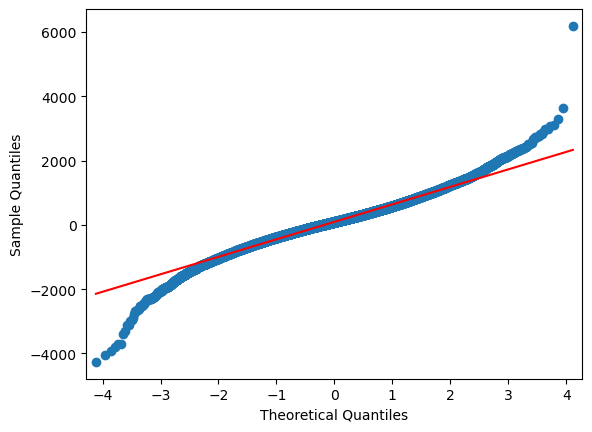

In [112]:
import numpy as np 
import statsmodels.api as sm 
import pylab as py 

sm.qqplot(h_sud["SBIL_MWH"], line='s')

py.show()

In [113]:
from scipy.stats import kstest, norm
my_data = norm.rvs(size=1000)
ks_statistic, p_value = kstest(h_sud["SBIL_MWH"], cdf="norm")
print(ks_statistic, p_value)

# Hypothesis test result:
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject H0: The data does not follow a normal distribution (H1).")
else:
    print("Fail to reject H0: The data follows a normal distribution (H0).")

0.5779565217739943 0.0
Reject H0: The data does not follow a normal distribution (H1).


In [114]:
from statsmodels.tsa.stattools import adfuller

# Assuming h_nord["SBIL_MWH"] is your time series data
adf_result = adfuller(h_sud["SBIL_MWH"])

# Print the result of the test
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Used Lag:", adf_result[2])
print("Number of Observations Used:", adf_result[3])
print("Critical Values:", adf_result[4])
print("  ")
# Hypothesis test result:
alpha = 0.05  # significance level

# Interpret the result based on p-value
if adf_result[1] < alpha:
    print("Reject H0: The time series is stationary (H1).")
else:
    print("Fail to reject H0: The time series is non-stationary (H0).")

ADF Statistic: -19.674353586276457
p-value: 0.0
Used Lag: 49
Number of Observations Used: 51398
Critical Values: {'1%': -3.4304772350406365, '5%': -2.8615962353086095, '10%': -2.566799932189033}
  
Reject H0: The time series is stationary (H1).


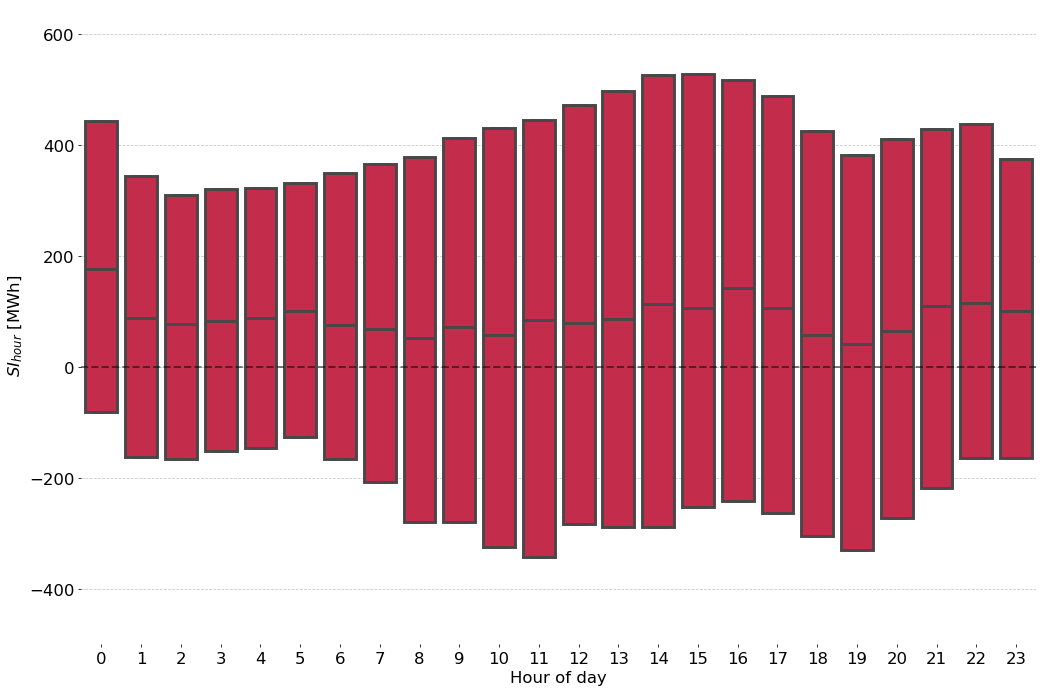

In [115]:
DPI = 70

# Ensure you are working on a copy of the DataFrame
h_sud_copy = h_sud.copy()

# Extract hour from the ORAINI index and create a new column 'hour' using .loc
h_sud_copy.loc[:, 'hour'] = h_sud_copy.index.hour

# Create the plot figure and axis
fig, ax = plt.subplots(figsize=(15, 10), dpi=DPI)

# Create a boxplot for SBIL_MWH over the hours of the day
sns.boxplot(data=h_sud_copy, x="hour", y="SBIL_MWH", fliersize=0, whis=0, color='crimson', linewidth=3, ax=ax)

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=17)
ax.tick_params(axis="both", which="minor", labelsize=17)

# Set labels for the axes
ax.set_xlabel("Hour of day", fontsize=17)
ax.set_ylabel("$SI_{hour}$ [MWh]", fontsize=17)

# Set the background color
fig.set(facecolor="#FFFFFF")
ax.set(facecolor="#FFFFFF")

# Hide specific plot spines
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Add a horizontal line at y=0
ax.axhline(0, color="black", ls="--", linewidth=2, alpha=0.5)

# Add horizontal grid lines
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limits
plt.ylim([-500, 650])

# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()


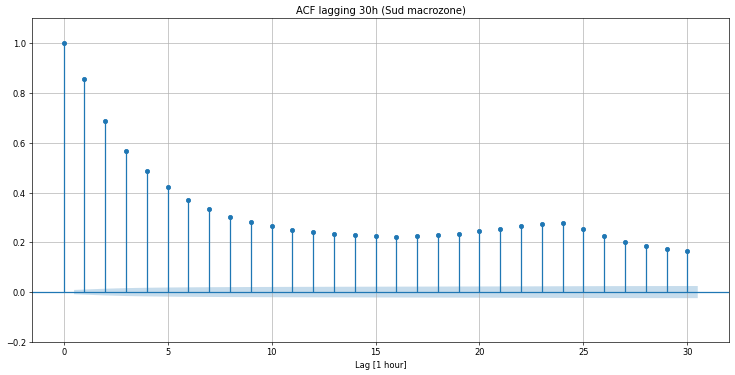

In [116]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_sud["SBIL_MWH"], alpha=.05, lags=30,
                         ax=ax, title="ACF lagging 30h (Sud macrozone)")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()

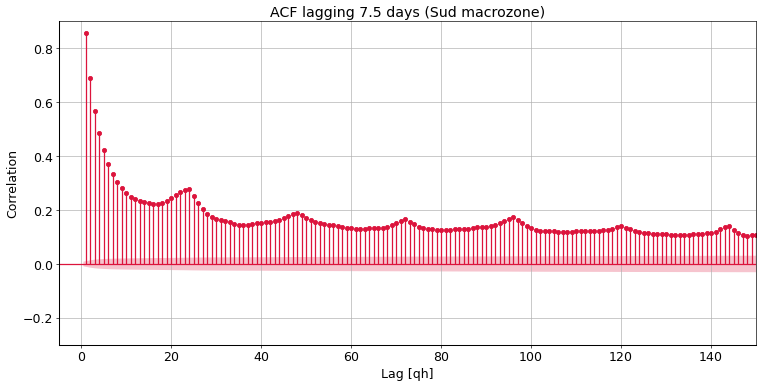

In [117]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_sud["SBIL_MWH"], alpha=.05, lags=24*7.5,
                         zero=False,
                         ax=ax,
                         color="crimson", vlines_kwargs={"colors": "crimson"})

ax.set_title("ACF lagging 7.5 days (Sud macrozone)", fontsize=17)
plt.ylim(-0.3, 0.9)
plt.xlim(-5, 24*7.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [qh]", fontsize=15)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("crimson")
plt.grid()
plt.show()

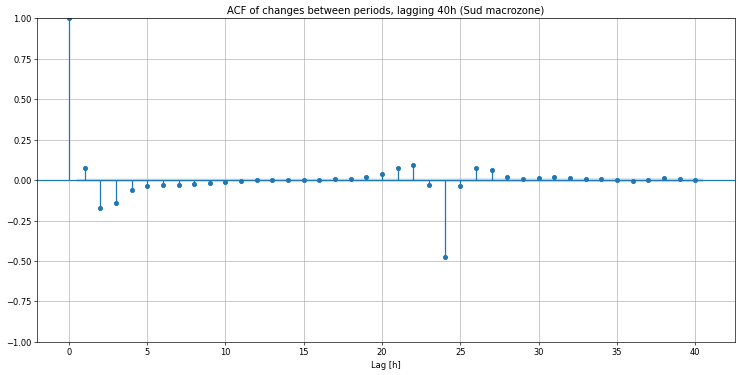

In [118]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_acf(h_sud["SBIL_MWH"].diff().diff(24).dropna(), alpha=.05, lags=40,
                         ax=ax, title="ACF of changes between periods, lagging 40h (Sud macrozone)")
# plt.ylim(-0.3, 1.1)
plt.xlabel('Lag [h]')
plt.grid()
plt.show()

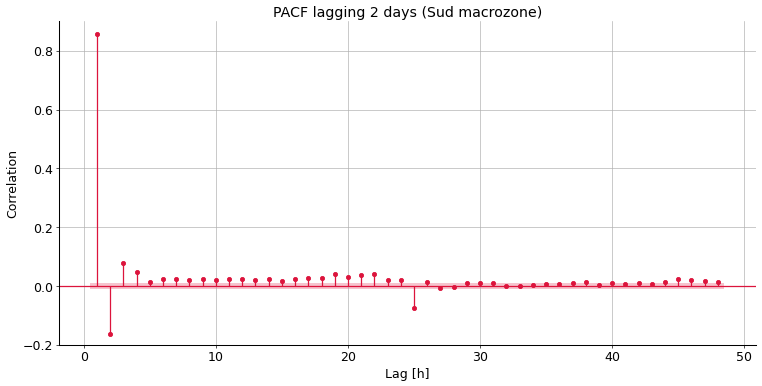

In [119]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=60)
sm.graphics.tsa.plot_pacf(h_sud["SBIL_MWH"], alpha=.05, lags=24*2, 
                         zero=False,
                         ax=ax,
                         color="crimson", vlines_kwargs={"colors": "crimson"})
plt.ylim(-0.2, 0.9)
# plt.xlim(-5, 4*24*2.5-30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Correlation", fontsize=15)
plt.xlabel("Lag [h]", fontsize=15)
ax.set_title("PACF lagging 2 days (Sud macrozone)", fontsize=17)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_linewidth(1.25)
ax.spines["bottom"].set_linewidth(1.25)
for item in ax.collections:
    if type(item)==PolyCollection:
        item.set_facecolor("crimson")
plt.grid()
plt.show()

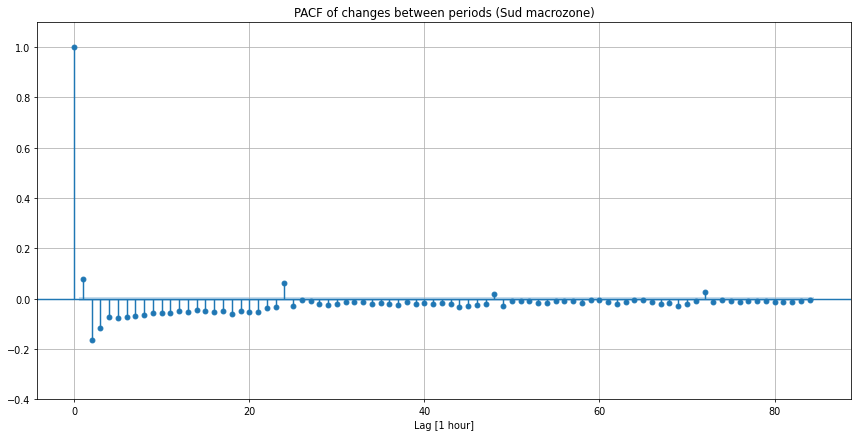

In [120]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=DPI)
sm.graphics.tsa.plot_pacf(h_sud["SBIL_MWH"].diff().dropna(), alpha=.05, lags=24*3.5, method="ywm", 
                          ax=ax, title="PACF of changes between periods (Sud macrozone)")
plt.ylim([-0.4,1.1])
plt.xlabel('Lag [1 hour]')
plt.grid()
plt.show()

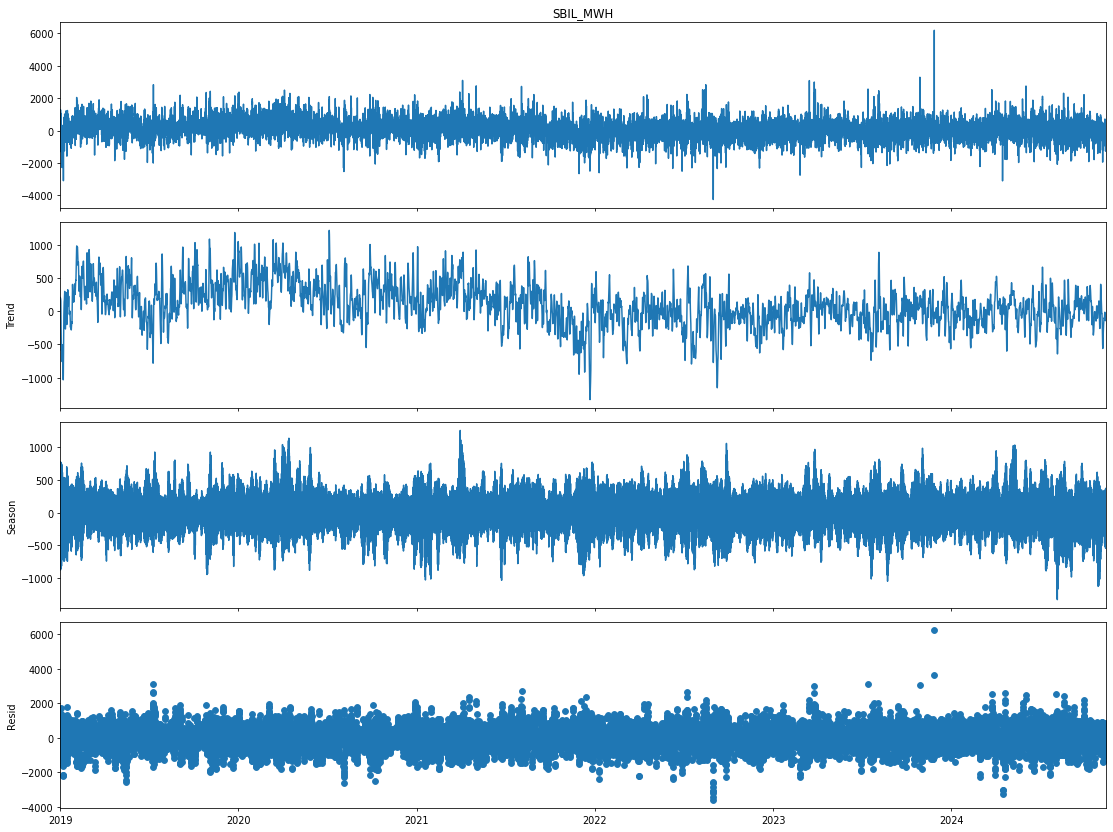

In [121]:
try_STL = True

if try_STL:
    decomp = STL(endog=h_sud["SBIL_MWH"], robust = True).fit()

    plt.rc('figure', figsize=(16, 12), dpi=DPI)
    decomp.plot()
    plt.show()
    plt.rcdefaults()